# Pt2FE
- This is a demo for applying the Pt2FE method
- The demo are arranged in the following steps:
    - 1) Data Preparing
    - 2) Data Processing
    - 3) 3D Reconstruction
    - 4) Convert into ANSYS APDL workflow (FE Model)
- Although I called this demo as automatic, but somehow I have to admit that this demo was actually semi-auto to use. Since some parameters you need to decide by yourself.

## Now, let's get started

## PART 1 : DATA PREPARING

- So, just put your orginal pointcloud data into the data/org_data file.
- Make sure that your file could be opened in the PointCloud software like CloudCompare or Geomagic Wrap...... in another word, make sure your file is .pcd(binary).
    - During the further steps, we may need several kinds of data format (.pcd(binary),.pcd(ascii),.csv and so on), so we prepared the format transformation function in the same-name file.
- The unit of your Pts data should consistent with the reality.

#### let us use the open3d lib to have quick glance of your data.

In [50]:
import open3d as o3d
from data_preparing.visualize_pt import visualize_pcds

In [2]:
visualize_pcds(['data/org_data/jie5.pcd'])

In [2]:
file_name = "jie5"

- Compare the PointCloud data with your original one, make sure that they are formally same with each other

- Then, we can transfer your orginal .pcd file into different format

In [49]:
# transfer your original file
from format_transformation.ascii_to_binary import ascii_to_binary
from format_transformation.binary_to_ascii import binary_to_ascii
from format_transformation.pcd2txt import pcd_to_txt
from format_transformation.txt_2_csv import txt_to_csv
from format_transformation.asc_adjust import process_ascii_pcd, process_ascii_pcd_rgb

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [13]:
#ascii_to_binary(f"./data/org_data/{file_name}.pcd",f"./data/org_data/data_{file_name}_b.pcd")

In [4]:
binary_to_ascii(f"./data/org_data/{file_name}.pcd",f"./data/org_data/{file_name}_asc_temp.pcd")

Hello, world!
PointCloud_source has: 398154 data points.


In [5]:
#adjust the asc_data in order to make the format of the file are the same
process_ascii_pcd_rgb(f"./data/org_data/{file_name}_asc_temp.pcd",f"./data/org_data/{file_name}_asc.pcd")

In [6]:
ascii_to_binary(f"./data/org_data/{file_name}_asc.pcd",f"./data/org_data/{file_name}_b.pcd")

In [7]:
pcd_to_txt(f"./data/org_data/{file_name}_asc.pcd", f"./data/org_data/{file_name}_txt.txt")

In [8]:
txt_to_csv(f"./data/org_data/{file_name}_txt.txt", f"./data/org_data/{file_name}_csv.csv")

In [9]:
import pandas as pd

In [10]:
csv_file = pd.read_csv(f"./data/org_data/{file_name}_csv.csv")
csv_file.drop(0,inplace=True)
#csv_file.reset_index(drop=True, inplace=True)
csv_file.to_csv(f"./data/org_data/{file_name}_csv.csv", index=False)

c:\Users\ADMIN\.conda\envs\pointcloud\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## PART 2 : DATA PROCESSING

- Now, we are going to the data processing step.

### 2.1 : Coordinate Adjustment

- If your data are offset with the reality, you may could apply this part
- In this section, we may also use plane fitting method, which we would discuss later in section 2.2

- 2.1.1 clustering the data in order to find the different planes in your data

In [51]:
#2.1.1 clustering the data in order to find the different planes in your data
import numpy as np

from data_processing.algorithm_clustering.points_to_surface3 import initialize_planes_with_kmeans, refine_planes

In [52]:
points_sample = np.loadtxt(f'./data/org_data/{file_name}_txt.txt',skiprows=1)
n_planes = 3

In [53]:
initial_planes = initialize_planes_with_kmeans(points_sample, n_planes)
refined_planes, refined_assignments = refine_planes(points_sample, initial_planes)

In [54]:
#visualization
from data_processing.algorithm_clustering.points_to_surface3 import plot_points_by_group

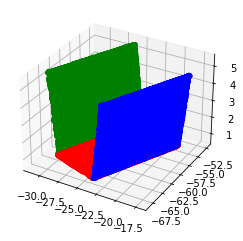

In [55]:
plot_points_by_group(points_sample, refined_assignments)

- To see whether if the result does make sense to the reality. (Each color represent to a plane) 
- The Relationship between color and plane number:
    - ['r', 'g', 'b','orange','purple','black']

In [56]:
#将结果存入.csv文件
import pandas as pd
ass_series = pd.Series(refined_assignments)
csv_file = f'./data/org_data/{file_name}_csv.csv'
df = pd.read_csv(csv_file)
df['cluster'] = ass_series
df.to_csv(f"./data/org_data/{file_name}_clu.csv", index=False)

- visualize the planes

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

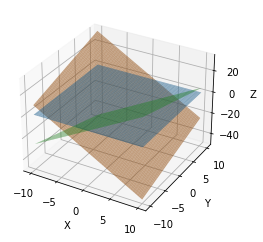

In [58]:
#visualize the planes that we fitted
planes_fig = refined_planes

# 创建数据点
x = np.linspace(-10, 10, 100) #绘图范围
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)

# 创建3D图形
fig = plt.figure()
plt3d = fig.add_subplot(111, projection='3d')

# 绘制多个平面
for plane in planes_fig:
    A, B, C, D = plane
    z = (-A * x - B * y - D) / C
    plt3d.plot_surface(x, y, z, alpha=0.5)

# 设置坐标轴标签
plt3d.set_xlabel('X')
plt3d.set_ylabel('Y')
plt3d.set_zlabel('Z')

# 显示图形
plt.show()

- 2.1.2 Transform the Point Clouds data
    - literally contains 2 steps:
        - Find Which point are going to transform to (0,0,0)
        - Let the bottom surface align with the standard surrface Z=0 (ignore this step in this demo)
    - However, if the model do not have a original bottom surface, using the intersection line to be the transformation object is also OK 

In [59]:
#from data_processing.transformation_PT import transform_points v1版本:仅平移
from data_processing.coordinate_transformation.trans import align_and_translate_point_cloud #v2版本:主成分分析找旋转方向；平移

In [7]:
import os
# 假设 rotated_points 是你需要保存的numpy数组
# rotated_points = np.array(...) 

output_path = "./data/rotated_data"
output_file = f"{file_name}_rot_pcd_b.pcd"
full_path = os.path.join(output_path, output_file) #创建相应文件夹和.txt文件

# 确保目标路径存在
os.makedirs(output_path, exist_ok=True)

In [9]:
points_path = f'.\data\org_data\{file_name}_b.pcd'
points_to_origin = np.array([-2.107190,-6.126470,0.653520]) #select by human

aligned_pcd = align_and_translate_point_cloud(points_path,full_path,np.array([-2.107190,-6.126470,0.653520]))

#np.savetxt("./data/rotated_data/data_rot_txt.txt", rotated_points)
#pd.DataFrame(rotated_points,columns=["x","y","z"]).to_csv("./data/rotated_data/data_rot_csv.csv",index=False)

In [10]:
#binary ----> ascii
from format_transformation.binary_to_ascii import binary_to_ascii

In [11]:
binary_to_ascii(full_path, output_path+f"/{file_name}_rot_pcd_asc.pcd")

Hello, world!
PointCloud_source has: 398154 data points.


In [12]:
from format_transformation.pcd2txt import pcd_to_txt_without_xyz,pcd_to_txt

In [13]:
pcd_to_txt_without_xyz(output_path+f"/{file_name}_rot_pcd_asc.pcd", output_path+f"/{file_name}_rot_txt.txt")

In [16]:
#csv版本
pcd_to_txt(output_path+f"/{file_name}_rot_pcd_asc.pcd", output_path+f"/{file_name}_rot_txt_xyz.txt")
txt_to_csv(output_path+f"/{file_name}_rot_txt_xyz.txt", output_path+f"/{file_name}_rot_csv.csv")

- OPTIMIZE THE ROTATED FUNCTION
    - By using the PCA to find out the main direction
    - Then select the point which is aiming to transform to (0,0,0) 

In [36]:
#import pandas as pd
#pd.DataFrame(rotated_points,columns=["x","y","z"]).to_csv(output_path+"/data_rot_csv.csv",index=False)

- P.S. : Sometimes, the transformation funtion might not be the same with the above ones!!!

- 2.1.3 Now, we can have a quick glance of what the point cloud model looks like after the format transformation

In [6]:
# from format_transformation.txt2pcd import txt_to_pcd

In [38]:
# txt_file_path = './data/rotated_data/data_rot_txt.txt'  # Replace with your .txt file path
# pcd_file_path = './data/rotated_data/data_rot_asc.pcd'     # The path for the output .pcd file

# txt_to_pcd(txt_file_path, pcd_file_path)

In [39]:
# file_a = 'data/org_data/data_org.pcd'
# file_b = 'data/rotated_data/data_rot_asc.pcd'
# visualize_pcds([file_a, file_b])

- Now, we get the model after coordinate correlation!

### 2.2 : Plane Fitting (Clustering)
- We use the model that after coordinate correlation

In [41]:
file_name="jie5"

In [44]:
#重新用一遍空间拟合平面操作
points_sample = np.loadtxt(f'./data/rotated_data/{file_name}_rot_txt.txt',skiprows=1)
n_planes = 3

In [45]:
points_sample

array([[-19.47133064, -58.804142  ,   0.67208004],
       [-19.46520805, -58.7919426 ,   0.67832005],
       [-19.45786285, -58.80080795,   0.63401997],
       ...,
       [ -8.22943973, -49.81418991,   4.51732969],
       [ -8.22740269, -49.79817963,   4.51058006],
       [ -8.21291256, -49.80495071,   4.51674986]])

In [46]:
initial_planes = initialize_planes_with_kmeans(points_sample, n_planes)
refined_planes, refined_assignments = refine_planes(points_sample, initial_planes)

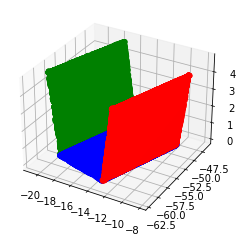

In [47]:
#visualize again
plot_points_by_group(points_sample, refined_assignments)

In [48]:
refined_planes

[array([ 0.91266505, -0.24876394, -0.3242823 , -3.36186707]),
 array([ 0.91101995, -0.25004844,  0.32790003,  2.80859534]),
 array([-0.00583231, -0.00123819,  0.99998223, -0.2656794 ])]

In [26]:
len(refined_assignments)

50560

In [27]:
import pandas as pd
ass_series = pd.Series(refined_assignments)

In [31]:
csv_file = f'./data/rotated_data/{file_name}_rot_csv.csv'
df = pd.read_csv(csv_file)
df.drop(0,inplace=True)
#df.shape
df['cluster'] = ass_series
df.to_csv(f"./data/rotated_data/{file_name}_rot_clu.csv", index=False)

- Honestly Speaking, we can simply just copy the column "cluster"'s value that we got from step 2.1.1

In [32]:
# 再求面方程
plane_coef = fit_planes_from_csv(f"./data/rotated_data/{file_name}_rot_clu.csv")
plane_coef

{0.0: [-0.002331595, 0.94476753, 0.32773316, 2.8621128],
 1.0: [0.0032350726, 0.00033115223, -0.9999948, 0.02025736],
 2.0: [-0.0017677681, -0.9489228, 0.31550384, 3.2194173]}

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

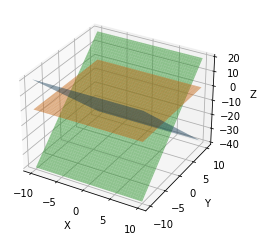

In [34]:
#visualize the planes that we fitted
planes_fig = list(plane_coef.values())

# 创建数据点
x = np.linspace(-10, 10, 100) #绘图范围
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)

# 创建3D图形
fig = plt.figure()
plt3d = fig.add_subplot(111, projection='3d')

# 绘制多个平面
for plane in planes_fig:
    A, B, C, D = plane
    z = (-A * x - B * y - D) / C
    plt3d.plot_surface(x, y, z, alpha=0.5)

# 设置坐标轴标签
plt3d.set_xlabel('X')
plt3d.set_ylabel('Y')
plt3d.set_zlabel('Z')

# 显示图形
plt.show()

In [35]:
refined_planes

[array([ 1.03809135e-03, -9.47046368e-01, -3.21095156e-01, -2.87801031e+00]),
 array([-3.23418163e-03, -8.10334738e-04,  9.99994442e-01, -1.96634962e-02]),
 array([-8.49321337e-04, -9.50790720e-01,  3.09832672e-01,  3.23423103e+00])]

- Each surface, we got a group of file to save the data. (每个面用一组数据进行单独储存)

In [1]:
from data_processing.save_by_dif_csv import save_clusters_to_csv

In [46]:
save_clusters_to_csv("./data/rotated_data/data_rot_clu.csv")

Saved to: plane_0.csv
Saved to: plane_1.csv
Saved to: plane_2.csv


In [2]:
from format_transformation.csv2txt import csv_to_txt

In [4]:
n_planes = 3
#csv ----> txt
for i in range (0, n_planes):
    input = f'./data/rotated_data/plane_{i}/plane_{i}.csv'
    output = f'./data/rotated_data/plane_{i}/plane_{i}.txt'

    csv_to_txt(input,output)   

In [7]:
# txt ----> pcd
for i in range (0, n_planes):
    input = f'./data/rotated_data/plane_{i}/plane_{i}.txt'
    output = f'./data/rotated_data/plane_{i}/plane_{i}_acs.pcd'

    txt_to_pcd(input,output)   

- python.open3d处理binary编码的点云文件,故因此需要格式转化

In [9]:
#ascii ----> binary
for i in range (0, n_planes):
    input = f'./data/rotated_data/plane_{i}/plane_{i}_acs.pcd'
    output = f'./data/rotated_data/plane_{i}/plane_{i}_bin.pcd'

    ascii_to_binary(input,output)   

### 2.3 : Extract Key Point 

- In this section, we find the key point (centroid point) individually from each plane
- This procedure contains 8 steps:
    - Get the .pcd file (which we already generated in 2.2)
    - Use "slicing_pt_multi_v2" get the first direction sliced
    - Use "slicing_pt_multi_2_v2"
    - dealing with the split dat
    - final_info_process to combine the above steps
    - generate final parts
    - Calculate the centroid point

- 2.3.1 Slicing in first direction

In [17]:
from data_processing.extract_key_point.slicing_pt_multi_v2 import slice_and_save_point_clouds

In [6]:
import open3d as o3d
import os
import numpy as np

In [31]:
#处理哪个面 (从面0开始计数！)
flag = 2

In [32]:
#define the slicing params (direction, distance)
direction = np.array([1, 0, 0])
slice_distance = 0.5 #切分距离
gap_distance = 1

In [33]:
#define some params
pcd = o3d.io.read_point_cloud(f"./data/rotated_data/plane_{flag}/plane_{flag}_bin.pcd")

output_path_pcd = f"./data/slicing_data/plane_{flag}/data_slicing_1"
output_path_csv = f"./data/slicing_data/plane_{flag}/data_csv"
#output_file = f"plane{flag}_split"
#full_path = os.path.join(output_path, output_file) #创建相应文件夹和.txt文件

# 确保目标路径存在
os.makedirs(output_path_pcd, exist_ok=True)
os.makedirs(output_path_csv, exist_ok=True)

In [34]:
slice_and_save_point_clouds(pcd, direction, slice_distance, gap_distance, output_path_pcd, output_path_csv, flag)

Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_0.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_1.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_2.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_3.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_4.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_5.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_6.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_7.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_8.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_9.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_10.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_11.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_12.pcd
Saved slice to ./data/slicing_data/plane_2/data_slicing_1/slice_13.pcd
Saved slice to .

- Until now, we got the slicing data in first direction

- 2.3.2 Slicing in second direction

In [35]:
from data_processing.extract_key_point.slicing_pt_multi_2_v2 import process_folder

In [36]:
direction = np.array([0, 0, 1])
#direction = np.array([0,1,0]) #水平面专用
slice_distance = 0.5
gap_distance = 1

In [37]:
#define path 2
input_folder = f"./data/slicing_data/plane_{flag}/data_slicing_1"

output_path = f"./data/slicing_data/plane_{flag}/data_slicing_2"
info_path = f"./data/slicing_data/plane_{flag}/data_slicing_2/info"
#output_file = f"plane{flag}_split"
#full_path = os.path.join(output_path, output_file) #创建相应文件夹和.txt文件

# 确保目标路径存在
os.makedirs(output_path, exist_ok=True)
os.makedirs(info_path, exist_ok=True)

In [38]:
process_folder(input_folder, direction, slice_distance, gap_distance, output_path)

Saved ./data/slicing_data/plane_2/data_slicing_2\slice_0_slice_with_gap_000.pcd
Saved slice data to ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_000.csv
Saved ./data/slicing_data/plane_2/data_slicing_2\slice_0_slice_with_gap_001.pcd
Saved slice data to ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_001.csv
Saved ./data/slicing_data/plane_2/data_slicing_2\slice_0_slice_with_gap_002.pcd
Saved slice data to ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_002.csv
Saved ./data/slicing_data/plane_2/data_slicing_2\slice_0_slice_with_gap_003.pcd
Saved slice data to ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_003.csv
Saved ./data/slicing_data/plane_2/data_slicing_2\slice_0_slice_with_gap_004.pcd
Saved slice data to ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_004.csv
Saved ./data/slicing_data/plane_2/data_slicing_2\slice_0_slice_with_gap_005.pcd
Saved slice data to ./dat

- Now, we finished splitting the Point Cloud data!

- 2.3.3 Deal with the split data
    - 去掉 0 行（无效行）
    - 匹配对应行数据到原模型中 （因为在求质心时，我们使用原模型坐标进行求解）

In [39]:
from data_processing.extract_key_point.deal_split_data import process_csv_files

In [40]:
input_folder = f'./data/slicing_data/plane_{flag}/data_slicing_2/info/'

In [41]:
process_csv_files(input_folder)

Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_000.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_001.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_002.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_003.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_004.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_005.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_006.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_007.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_0_slice_with_gap_008.csv
Processed and saved ./data/slicing_data/plane_2/data_slicing_2/info/slice_10_slice_with_gap_000.csv
Processed

In [42]:
import pandas as pd

In [43]:
#得到plane_sli_info_1.csv文件 (第一次切分区域匹配)
slice1_data = pd.read_csv(f"./data/slicing_data/plane_{flag}/data_csv/points_slice_info_plane{flag}.csv")
plane_sli_info = slice1_data.iloc[:,0:4]
plane_sli_info.to_csv(f"./data/slicing_data/plane_{flag}/data_csv/plane_sli_info_1.csv",index=False)

In [44]:
from data_processing.extract_key_point.deal_split_data import update_target_with_p_XY
from data_processing.extract_key_point.deal_split_data import update_target_with_p_XZ

- 立面应用update_target_with_p_XZ， 水平面应用update_target_with_p_XY

In [45]:
slice2_data = pd.read_csv(f"./data/slicing_data/plane_{flag}/data_csv/points_adjusted_positions_plane{flag}.csv")
slice2_data.to_csv(f"./data/slicing_data/plane_{flag}/data_csv/plane_sli_info_2.csv",index=False)

In [46]:
#得到plane_sli_info_2.csv文件
folder_path = f'./data/slicing_data/plane_{flag}/data_slicing_2/info'  # 替换为实际的文件夹路径
target_csv_path = f'./data/slicing_data/plane_{flag}/data_csv/plane_sli_info_2.csv'  # 替换为实际的目标CSV文件路径

In [47]:
#水平面
#update_target_with_p_XY(folder_path, target_csv_path)

#立面
update_target_with_p_XZ(folder_path, target_csv_path)

Processing files: 100%|██████████| 289/289 [27:34<00:00,  5.73s/it]


Updated target CSV at ./data/slicing_data/plane_2/data_csv/plane_sli_info_2.csv


- 这样的匹配方式基于一个小trick，就是点云数据的存储.csv文件，其“存储顺序”不会发生改变

- 2.3.4 Combine 2 slicing_data.csv
    - Combine plane_sli_info_1.csv & plane_sli_info_2.csv

In [48]:
file_1 = pd.read_csv(f"./data/slicing_data/plane_{flag}/data_csv/plane_sli_info_1.csv")
file_1.head()

,X,Y,Z,Slice_Index
0,-0.212528,-3.159503,0.288085,0.0
1,-0.211027,-3.246203,0.534179,0.0
2,-0.208232,-3.091612,0.082519,0.0
3,-0.207352,-3.168567,0.326171,0.0
4,-0.207045,-3.142616,0.269531,0.0


In [49]:
file_2 = pd.read_csv(f"./data/slicing_data/plane_{flag}/data_csv/plane_sli_info_2.csv")
file_2.head()

,Adjusted_X,Adjusted_Y,Adjusted_Z,Slice_Index
0,-0.212528,-3.159503,0.288085,0.0
1,-0.211027,-3.246203,0.534179,1.0
2,-0.208232,-3.091612,0.082519,0.0
3,-0.207352,-3.168567,0.326171,0.0
4,-0.207045,-3.142616,0.269531,0.0


In [50]:
file_fin = pd.DataFrame()

In [51]:
file_fin["X"] = file_1["X"]
file_fin["Y"] = file_1["Y"]
file_fin["Z"] = file_1["Z"]
file_fin["Slice_Index_1"] = file_1["Slice_Index"]
file_fin["Slice_Index_2"] = file_2["Slice_Index"]

file_fin.head()

,X,Y,Z,Slice_Index_1,Slice_Index_2
0,-0.212528,-3.159503,0.288085,0.0,0.0
1,-0.211027,-3.246203,0.534179,0.0,1.0
2,-0.208232,-3.091612,0.082519,0.0,0.0
3,-0.207352,-3.168567,0.326171,0.0,0.0
4,-0.207045,-3.142616,0.269531,0.0,0.0


In [52]:
file_fin.to_csv(f"./data/slicing_data/plane_{flag}/data_csv/file_fin_plane{flag}.csv",index=False)

- 2.3.5 Generate Final pcd file of the targeted plane

In [53]:
import os

In [54]:
output_path = f"./data/slicing_data/plane_{flag}/fin_point"

# 确保目标路径存在
os.makedirs(output_path, exist_ok=True)

In [55]:
from data_processing.extract_key_point.generate_final_parts import save_groups_to_pcd

In [56]:
csv_file_path = f"./data/slicing_data/plane_{flag}/data_csv/file_fin_plane{flag}.csv"
output_path = f"./data/slicing_data/plane_{flag}/fin_point"
save_groups_to_pcd(csv_file_path, output_path)

Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_0.0.pcd with 21 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_1.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_2.0.pcd with 22 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_3.0.pcd with 21 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_4.0.pcd with 22 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_5.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_6.0.pcd with 20 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_7.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_8.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_1.0_0.0.pcd with 18 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_1.0_1.0.pcd with 27 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_1.0_2.0.

- 2.3.6 Calculate the Centroid Point

In [57]:
from data_processing.extract_key_point.centroid_point import calculate_centroids_and_save

In [58]:
input_folder = f"./data/slicing_data/plane_{flag}/fin_point"
output_path = "./data/centroid_data"
output_file = output_path + f"/plane{flag}_centroids.pcd"

os.makedirs(output_path, exist_ok=True)

In [59]:
calculate_centroids_and_save(input_folder, output_file)

Saved centroid point cloud to ./data/centroid_data/plane2_centroids.pcd


- By then, we got the centroid point of the target plane!

- By doing this for n times, we can get the centroid points for each plane

### 2.4 : Supplementary operation

- We also need to do some extra works for acquiring a better model

- 2.4.1 calculate the intersection line of each 2 planes & generate virtual point cloud for connecting planes

In [60]:
from data_processing.surface_intersection_line import find_intersection_point, cross_product

In [76]:
refined_planes

[array([-8.45630394e-04, -9.50798637e-01,  3.09808388e-01,  3.23398910e+00]),
 array([-0.00322006, -0.00111234,  0.9999942 , -0.01966359]),
 array([ 1.03347937e-03, -9.47036720e-01, -3.21123626e-01, -2.87827417e+00])]

In [106]:
#哪两个面进行求交线操作
a = 1
b = 0

In [107]:
direction = cross_product(np.array(refined_planes[a][:3]), np.array(refined_planes[b][:3]))
point_on_line = find_intersection_point(refined_planes[a], refined_planes[b], direction)
print(f"平面{a}和平面{b}的交线方向向量：",direction)
print(f"平面{a}和平面{b}的交线上的一点：",point_on_line)

平面1和平面0的交线方向向量： [9.50448507e-01 1.51975010e-04 3.06068465e-03]
平面1和平面0的交线上的一点： [0.         3.40898245 0.02345567]


In [108]:
start_point = np.array(point_on_line)
direction = np.array(direction)

# 归一化方向向量
direction_normalized = direction / np.linalg.norm(direction)
# 设定p_max的值
p_max = 17  # 假设值，根据需要调整
# 每隔0.5的距离
distance = 0.5

In [109]:
from tqdm import tqdm

In [110]:
# 计算预期的迭代次数
max_distance = p_max - start_point[0]
estimated_steps = int(max_distance / distance)

In [111]:
# 计算点的序列并加入tqdm进度条
points = []
current_point = start_point
# 使用tqdm包装range对象，提供预计的迭代次数
for _ in tqdm(range(estimated_steps), desc="Generating points"):
    if current_point[0] <= p_max:
        points.append(current_point)
        current_point = current_point + direction_normalized * distance
    else:
        break  # 如果当前点超过了最大值，则停止循环

Generating points: 100%|██████████| 34/34 [00:00<?, ?it/s]


In [112]:
points_array = np.array(points)
#print(points)

# 创建点云对象
point_cloud = o3d.geometry.PointCloud()

# 将NumPy数组中的点添加到点云中
point_cloud.points = o3d.utility.Vector3dVector(points_array)

output_path = "./data/extra_data"
os.makedirs(output_path, exist_ok=True)
# 保存点云到PCD文件
o3d.io.write_point_cloud(output_path + f"/extra_plane{a}_plane{b}.pcd", point_cloud, write_ascii=False)

True

In [115]:
visualize_pcds([f'data/extra_data/extra_plane{a}_plane{b}.pcd'
                ,f'./data/centroid_data/plane{a}_centroids.pcd'
                ,f'./data/centroid_data/plane{b}_centroids.pcd'])

- 如果与实际情况不相符，请尝试调转面a,b的赋值
- 若想求指定x数值的在交线上的起始点，请尝试调用find_point_on_line函数
- 若要求多组平面的相交线，请更改a,b值进行并重新运行本模块的代码

- 2.4.2 合并上述点云数据

In [2]:
from data_processing.extract_key_point.merge_pcd import merge_pcd_files

In [4]:
#merged centroid points
pcd_file_dir = "./data/centroid_data"
output_pcd_file = './data/centroid_data/merged_centroid.pcd'

merge_pcd_files(pcd_file_dir, output_pcd_file)

Saved merged point cloud to ./data/centroid_data/merged_centroid.pcd


In [7]:
#merged extra generated data (lines)
pcd_file_dir = "./data/extra_data"
output_pcd_file = './data/extra_data/merged_extra.pcd'

merge_pcd_files(pcd_file_dir, output_pcd_file)

Saved merged point cloud to ./data/extra_data/merged_extra.pcd


In [8]:
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud("./data/centroid_data/merged_centroid.pcd")
pcd_2 = o3d.io.read_point_cloud("./data/extra_data/merged_extra.pcd")

output_path = "./data/final_data"
file_name = "/final_point_cloud.pcd"
output_file = output_path + file_name

os.makedirs(output_path, exist_ok=True)

In [9]:
merged_pcd = pcd_1 + pcd_2

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/final_point_cloud.pcd


In [10]:
#分平面的点云数据
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud("./data/centroid_data/plane0_centroids.pcd")
pcd_2 = o3d.io.read_point_cloud("./data/extra_data/extra_plane1_plane0.pcd")

merged_pcd = pcd_1 + pcd_2

output_path = "./data/final_data"
file_name = "/final_point_cloud_p0.pcd"
output_file = output_path + file_name

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/final_point_cloud_p0.pcd


In [11]:
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud("./data/centroid_data/plane1_centroids.pcd")
pcd_2 = o3d.io.read_point_cloud("./data/extra_data/extra_plane1_plane0.pcd")
pcd_3 = o3d.io.read_point_cloud("./data/extra_data/extra_plane1_plane2.pcd")

merged_pcd = pcd_1 + pcd_2 + pcd_3

output_path = "./data/final_data"
file_name = "/final_point_cloud_p1.pcd"
output_file = output_path + file_name

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/final_point_cloud_p1.pcd


In [12]:
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud("./data/centroid_data/plane2_centroids.pcd")
pcd_2 = o3d.io.read_point_cloud("./data/extra_data/extra_plane1_plane2.pcd")

merged_pcd = pcd_1 + pcd_2

output_path = "./data/final_data"
file_name = "/final_point_cloud_p2.pcd"
output_file = output_path + file_name

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/final_point_cloud_p2.pcd


- 2.4.3 Format Transformation

In [12]:
flag = 2 #处理哪个面

In [13]:
from format_transformation.binary_to_ascii import binary_to_ascii

In [14]:
#.pcd ----> .csv
filename = f"./data/final_data/final_point_cloud_p{flag}.pcd"
output_filename = f"./data/final_data/final_point_cloud_p{flag}_ascii.pcd"

binary_to_ascii(filename, output_filename)

Hello, world!
PointCloud_source has: 323 data points.


In [15]:
from format_transformation.pcd2txt import pcd_to_txt

In [16]:
pcd_file = f"./data/final_data/final_point_cloud_p{flag}_ascii.pcd"
txt_file = f"./data/final_data/final_point_cloud_p{flag}_txt.txt"
pcd_to_txt(pcd_file, txt_file)

In [17]:
from format_transformation.txt_2_csv import txt_to_csv_with_columns

In [18]:
txt_file = f"./data/final_data/final_point_cloud_p{flag}_txt.txt"
csv_file = f"./data/final_data/final_point_cloud_p{flag}_csv.csv"

txt_to_csv_with_columns(txt_file, csv_file)

- For now, we finished the data processing part!

## PART 3 : 3D Reconstruction 

In [20]:
import os

In [21]:
td_path = "./data/TDR_data"
os.makedirs(td_path, exist_ok=True)

In [22]:
from TD_Reconstruction.bpa_plane import bpa_rec

In [23]:
from TD_Reconstruction.add_id import add_id

In [32]:
flag = 2

In [33]:
csv_file = f"./data/final_data/final_point_cloud_p{flag}_csv.csv"
updated_csv_file_path = f"./data/final_data/final_point_cloud_p{flag}_csv_id.csv" #用不用改成TD 文件夹？

add_id(csv_file, flag, updated_csv_file_path)

- id命名规则：面编号（从1开始）+ 点编号

In [34]:
csv_file = f"./data/final_data/final_point_cloud_p{flag}_csv_id.csv"
output_csv = f"./data/TDR_data/plane{flag}_REC.csv"

bpa_rec(csv_file, output_csv)

564


## PART 4 : Convert into ANSYS APDL

In [45]:
flag = 2

In [46]:
from TD_Reconstruction.csv2ansys import Generate_KP, Generate_AREA

In [47]:
output_path = "./data/TDR_data/ball_pivoting"
os.makedirs(output_path, exist_ok=True)

- 4.1 Generate Keypoints

In [48]:
csv_file = f"./data/final_data/final_point_cloud_p{flag}_csv_id.csv"
output_txt = f"./data/TDR_data/ball_pivoting/plane{flag}_KP.txt"

Generate_KP(csv_file, output_txt)

- 4.2 Generate AREA

In [49]:
csv_file = f"./data/TDR_data/plane{flag}_REC.csv"
output_txt = f"./data/TDR_data/ball_pivoting/plane{flag}_AREA.txt"

Generate_AREA(csv_file, output_txt)

- Now you may get 2*number of planes' ANSYS APDL File. That's what we need to build up the model in ANSYS. Just copy those file into your ANSYS APDL .txt file, and then add the material definition part and restraint part and load part .......